In [34]:
import pandas as pd
import numpy as np

from glob import glob

In [2]:
import os
import sys

current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(root_dir)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Experiment 1

LLaMA 3 8B and 70B models were used as the post-processing step. Only 1 single target fact was provided. The retain accuracy was calculated based on the 3 retain sets.

In [3]:
def get_accuracy(result):
    result = 1 - result
    result["forget"] = 1 - result["forget"]
    return result.sum() / len(result)

In [4]:
exp1_result_8b = pd.read_csv("../../outputs/experiment_2step_n1_i0.csv")
exp1_result_70b = pd.read_csv("../../outputs/experiment_2step_n1_i0_70b.csv")

Simple accuracy for forget and retain. (Assume the original model output is ground truth)

In [5]:
get_accuracy(exp1_result_8b)

forget             0.593985
retain_author      0.734336
retain_category    0.944862
retain_random      0.972431
dtype: float64

In [6]:
get_accuracy(exp1_result_70b)

forget             0.669173
retain_author      0.754386
retain_category    0.929825
retain_random      0.977444
dtype: float64

The string match and rouge metrics

In [19]:
from src.eval import Evaluation

response_df = pd.read_csv("../../data/forget10_with_responses.csv")

evaluator = Evaluation()

In [29]:
def get_retain_metrics_exp1(mask_df):
    cols = ["retain_author", "retain_category", "retain_random"]
    dfs = [
        pd.read_csv("../../data/retain_author_same.csv"),
        pd.read_csv("../../data/retain_category_same.csv"),
        pd.read_csv("../../data/retain_random.csv")
    ]
    df_joined = [
        pd.merge(df, response_df, left_on=["retain_question", "retain_answer"], right_on=["question", "answer"]) # retain response is "response_y"
        for df in dfs
    ]


    for i in range(3):
        merged_df = df_joined[i]
        col = cols[i]
        merged_df["unlearned_response"] = merged_df["response_y"].mask(mask_df[col] == 1, "")
        merged_df["answer"] = merged_df["retain_answer"]
        m1 = evaluator.get_retain_accuracy(merged_df, method="exact_string_match")
        m2 = evaluator.get_retain_accuracy(merged_df, method="rouge_l", rouge_recall_cutoff=0.9)
        print(f"{col}: string match {m1}, rogue {m2}")
        # Oracle: assume original response get outputted
        merged_df["unlearned_response"] = merged_df["response_y"]
        merged_df["answer"] = merged_df["retain_answer"]
        m1 = evaluator.get_retain_accuracy(merged_df, method="exact_string_match")
        m2 = evaluator.get_retain_accuracy(merged_df, method="rouge_l", rouge_recall_cutoff=0.9)
        print(f"Oracle for {col}: string match {m1}, rogue {m2}")

In [30]:
get_retain_metrics_exp1(exp1_result_8b)

retain_author: string match 0.2525, rogue 0.34
Oracle for retain_author: string match 0.355, rogue 0.4825
retain_category: string match 0.3157894736842105, rogue 0.44360902255639095
Oracle for retain_category: string match 0.3283208020050125, rogue 0.47619047619047616
retain_random: string match 0.355, rogue 0.475
Oracle for retain_random: string match 0.3725, rogue 0.4975


In [31]:
get_retain_metrics_exp1(exp1_result_70b)

retain_author: string match 0.2425, rogue 0.34
Oracle for retain_author: string match 0.355, rogue 0.4825
retain_category: string match 0.3057644110275689, rogue 0.43358395989974935
Oracle for retain_category: string match 0.3283208020050125, rogue 0.47619047619047616
retain_random: string match 0.36, rogue 0.4825
Oracle for retain_random: string match 0.3725, rogue 0.4975


# Experiment 2

8B model was used. The retain performance was calculated using sampled 

Forget performance

In [37]:
n_list = [3, 5, 7, 9, 15, 21]

acc_values = []

for n in n_list:
    dfs = [
        pd.read_csv(f"../../outputs/experiment_2step_n{n}_i0.csv"),
        pd.read_csv(f"../../outputs/experiment_2step_n{n}_i{n // 2}.csv"),
        pd.read_csv(f"../../outputs/experiment_2step_n{n}_i{n - 1}.csv")
    ]
    acc_values.append([df.sum()["forget"] / 399 for df in dfs])

forget_result = pd.DataFrame(
    acc_values,
    columns=["start", "middle", "end"],
    index=n_list
)

In [38]:
forget_result

,start,middle,end
3,0.749373,0.774436,0.799499
5,0.807018,0.804511,0.791980
7,0.751880,0.779449,0.771930
9,0.789474,0.771930,0.761905
15,0.731830,0.694236,0.696742
21,0.746867,0.676692,0.729323


<Axes: >

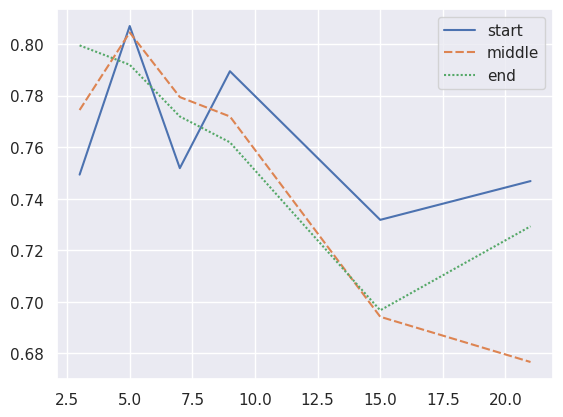

In [39]:
sns.lineplot(data=forget_result)

Retain performance

In [43]:
n_list = [5, 9, 15, 21]

acc_values = []

for n in n_list:
    dfs = [
        pd.read_csv(f"../../outputs/experiment_2step_n{n}_i0_retain.csv"),
        pd.read_csv(f"../../outputs/experiment_2step_n{n}_i{n // 2}_retain.csv"),
        pd.read_csv(f"../../outputs/experiment_2step_n{n}_i{n - 1}_retain.csv")
    ]
    acc_values.append([1 - df.sum()["multi_retain90"] / 399 for df in dfs])

retain_result = pd.DataFrame(
    acc_values,
    columns=["start", "middle", "end"],
    index=n_list
)

<Axes: >

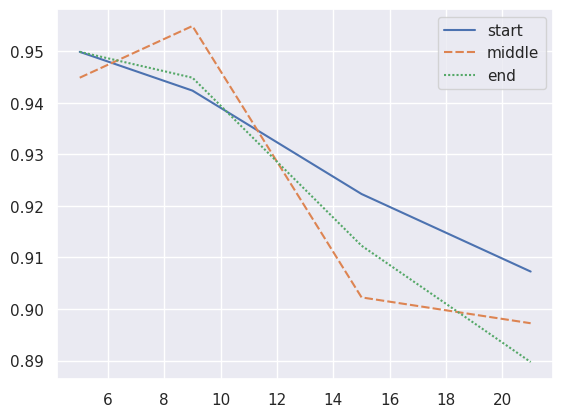

In [44]:
sns.lineplot(data=retain_result)